# Hyperparameter Optimisation with Weigths & Biases

This notebook contains the code which runs hyperparameter optimisation using the Weights & Biases platform for selected models, namely BERT, RoBERTa and Longformer.  

The base models are fetched from HuggingFace, after that they are fine-tuned with Pytorch. Training loop, dataloaders and evaluation code are provided in script files.  

The details of the implementation can be found in corresponding scripts as the notebook contains high-level code. 

The code was developed using the **Kaggle** platform, but it is adapted to be run on the **Google Colab** platform.

Essential things to have to run this notebook: 
1. Set the **BASE_PATH** which is the project directory to access the dataset and the code.
2. Make sure you have the data downloaded.
3. Weights & Biases account and provide the API key.
4. Choose the hyperparameters to tune with the ranges of values to consider. 


# Connect to the Google Drive

Firstly, connect to the Google Drive to be able to access files from there to read and store papers.

If other platform is used to run the notebook code, then comment this out. 

In [ ]:
from google.colab import drive, files

colab_path = '/content/drive'
drive.mount(colab_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install and Import Required Libraries for Tweets Topic Modelling

In [ ]:
#@title Install Libraries
!pip install transformers
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Essential Libraries

In [ ]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import wandb

# Define Paths and Import Local Scripts

Set the absolute paths for **BASE_PATH** and **DATA_PATH**.

In [ ]:
BASE_PATH = "/content/drive/MyDrive/Reviewer2"

DATA_PATH = f"{BASE_PATH}/ICLR_Dataset"

module_path = os.path.abspath(BASE_PATH)
if module_path not in sys.path:
    sys.path.append(module_path)


from scripts.data_reading import get_papers_paths, extract_documents_text, subsample_documents
from scripts.train_models import train_transformer_model
from scripts.utils import get_device

# Define Constants, Hyperparameters and Configurations

There are three models which can be selected from the Huggingface Hub by those strings:

1. BERT - "**bert-base-cased**"
2. RoBERTa - "**roberta-base**"
3. Longformer - "**allenai/longformer-base-4096**"

Their batch sizes:
1. BERT - 16
2. RoBERTa - 16
3. Longformer - 2

Their maximum token size:
1. BERT - 512
2. RoBERTa - 512
3. Longformer - 2048

They were run for 10 epochs. 

These paramaters are optimised:
1. **learning rate**
2. **weight decay**
3. **text splitting method**
4. **whether to include metadata**

In [ ]:
test_size = 0.2
random_state = 42

TEXT_SELECTION_MODES = {"INTRODUCTION_WITH_ABSTRACT": 0, 
                        "INTRODUCTION_WITHOUT_ABSTRACT": 1, 
                        "MIDDLE": 2, 
                        "TAIL": 3,
                        "ABSTRACT_WITH_TAIL": 4}

# Default Hyperparameters
epochs = 10
learning_rate = 5e-5
weight_decay = 0.01
add_paper_metadata = True
model_name = "roberta-base"
mode = TEXT_SELECTION_MODES["INTRODUCTION_WITHOUT_ABSTRACT"]

# For Longformer, this was used: MAX_TOKENS_NUMBER = 2048
# For BERT and RoBERTa, this was used: MAX_TOKENS_NUMBER = 512
MAX_TOKENS_NUMBER = 512

# For Longformer, this was used: batch_size = 2
# For BERT and RoBERTa, this was used: batch_size = 16
batch_size = 16

plt.rcParams["figure.figsize"] = (12, 6)

# Log in to Weights & Biasses and Configure a Sweep

**Note**: you must have an account and an API key to run this code.  

In [ ]:
wandb.login()

sweep_configuration = {
    'method': 'random',
    'name': 'Hyperparameter Optimisation for Paper Classification',
    'metric': {'goal': 'maximize', 'name': 'val_acc'},
    'parameters': 
    {
        'learning_rate': {'max': 9e-5, 'min': 1e-5},
        'weight_decay': {'max': 1e-0, 'min': 1e-3},
        'model_name': {'values': ["bert-base-cased", "roberta-base", "allenai/longformer-base-4096"]},
        'text_splitting_mode_name': {'values': list(TEXT_SELECTION_MODES.keys())},
        'included_metadata': {'values': [False, True]},
     }
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project='YOUR_PROJECT', entity="YOUR_ACCOUNT_NAME")

wandb: Currently logged in as: luksass (nlu-cw). Use `wandb login --relogin` to force relogin


Create sweep with ID: 6gtngidf
Sweep URL: https://wandb.ai/nlu-cw/nlu-cw/sweeps/6gtngidf


## Import the Paths of Stored Papers 

All details on how the data was preprocessed and split can be found in corresponding script file for data reading and preprocessing.

**Note** that the data reading for the first time of the runtime can run for about an hour for the whole dataset because of long read times from Google Drive. 

In [ ]:
paper_and_content_paths = get_papers_paths(DATA_PATH)

# Obtain the Device
Check if there is GPU Available preferably, as it would take a plethora of time to train on a CPU. 

In [ ]:
device = get_device()

There are 1 GPU(s) available.
GPU: Tesla T4


# Run the Sweep

This runs the Hyperparameter Sweep of selected parameters. 

In [ ]:
def train_sweep():
    """
    This method runs a sweep over selected hyperparameters.
    """
    # Initialize a new wandb run
    with wandb.init():
        # this config will be set by Sweep Controller
        config = wandb.config
        
        learning_rate = config.learning_rate
        model_name = config.model_name
        weight_decay = config.weight_decay
        included_metadata = config.included_metadata
        text_splitting_mode_name = config.text_splitting_mode_name

        # Set different parameters for batch size and maximum number of tokens depending on the model tested
        if model_name == "allenai/longformer-base-4096":
            MAX_TOKENS_NUMBER = 2048
            batch_size = 2
        else:
            MAX_TOKENS_NUMBER = 512
            batch_size = 16 

        text_splitting_mode = TEXT_SELECTION_MODES[text_splitting_mode_name]

        # Retrieve documents after setting the text splitting strategy
        documents, labels = extract_documents_text(paper_and_content_paths, mode=text_splitting_mode, add_paper_metadata=included_metadata)
        data_df = pd.DataFrame(data={"Docs": documents, "Decision": labels})
        
        subsampled_data_df = subsample_documents(data_df, random_state)
        
        # Obtain the original splits used in other notebooks to be consistent, but this may take long for the first run
        # to run the whole dataset 
        training_documents, _, training_labels, _ = train_test_split(subsampled_data_df.Docs.values, subsampled_data_df.Decision.values, 
                                                                                  test_size=test_size, random_state=random_state, 
                                                                                  stratify=subsampled_data_df.Decision)
        training_documents, val_documents, training_labels, val_labels = train_test_split(training_documents, training_labels, 
                                                                                  test_size=test_size, random_state=random_state, 
                                                                                  stratify=training_labels)

        # Train and evaluate the model on the val set
        model, model_performance, tokenizer = train_transformer_model(model_name, epochs, batch_size, learning_rate, 
                                                                      weight_decay, training_documents, val_documents, 
                                                                      training_labels, val_labels, device, 
                                                                      MAX_TOKENS_NUMBER, random_state)                                                                      
        wandb.log({
            'train_acc': model_performance[-1]["Training Accur."],
            'train_loss': model_performance[-1]["Training Loss"],
            'val_acc': model_performance[-1]["Valid. Accur."],
            'val_loss': model_performance[-1]["Valid. Loss"],
          })
        
        torch.cuda.empty_cache() 


wandb: Agent Starting Run: pvjy9cbz with config:
wandb: 	included_metadata: False
wandb: 	learning_rate: 5.397545759957105e-05
wandb: 	model_name: bert-base-cased
wandb: 	text_splitting_mode_name: TAIL
wandb: 	weight_decay: 0.36511577474889534


============ Transformer bert-base-cased is now being tested ============



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

  0%|          | 0/1380 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...


  Average training loss: 0.71
  Training epoch took: 0:03:24
  Training Accuracy: 0.50

Running Validation...
  Validation Accuracy: 0.50
Validation Loss: 0.70
Validation took: 0:00:17

======== Epoch 2 / 10 ========
Training...


  Average training loss: 0.70
  Training epoch took: 0:03:23
  Training Accuracy: 0.50

Running Validation...
  Validation Accuracy: 0.50
Validation Loss: 0.70
Validation took: 0:00:17

======== Epoch 3 / 10 ========
Training...


  Average training loss: 0.70
  Training epoch took: 0:03:24
  Training Accuracy: 0.51

Running Validation...
  Validation Accuracy: 0.50
Validation Loss: 0.70
Validation took: 0:00:18

======== Epoch 4 / 10 ========
Training...


  Average training loss: 0.71
  Training epoch took: 0:03:23
  Training Accuracy: 0.52

Running Validation...
  Validation Accuracy: 0.50
Validation Loss: 0.71
Validation took: 0:00:17

======== Epoch 5 / 10 ========
Training...


  Average training loss: 0.70


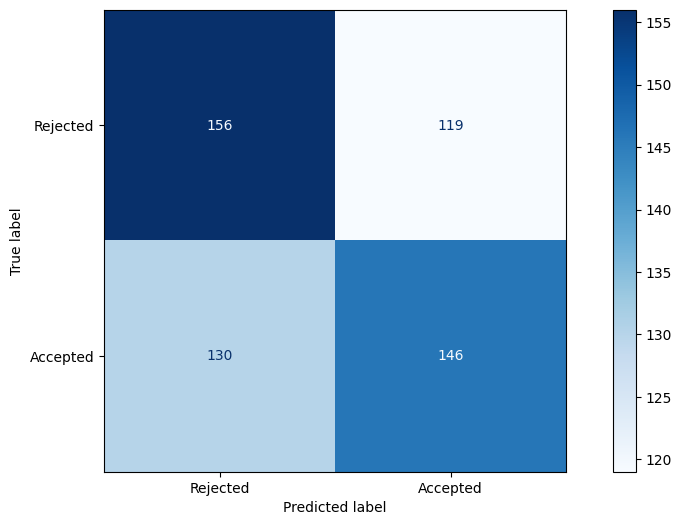

  Validation Accuracy: 0.55
Validation Loss: 1.05
Validation took: 0:00:18

Training complete!
Total training took 0:36:49 (h:mm:ss)


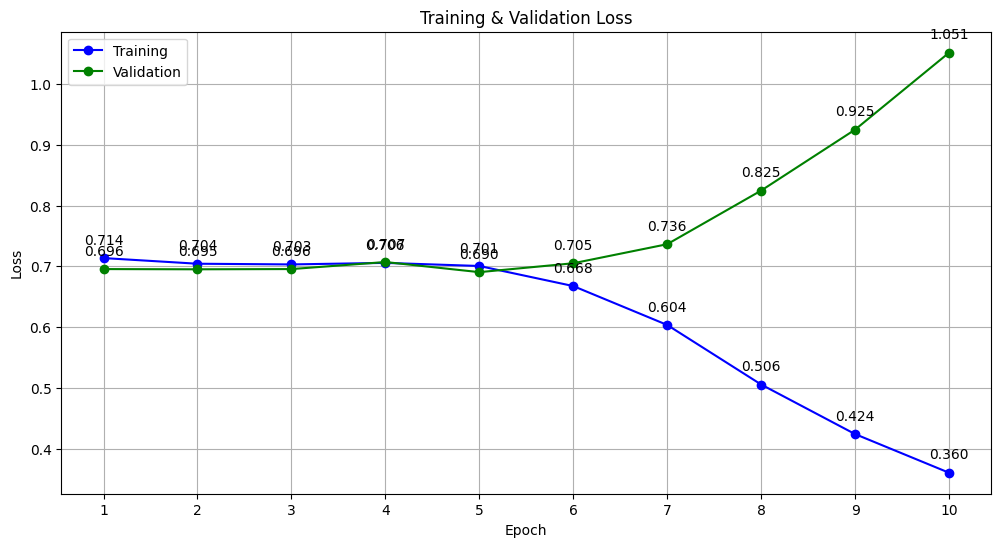

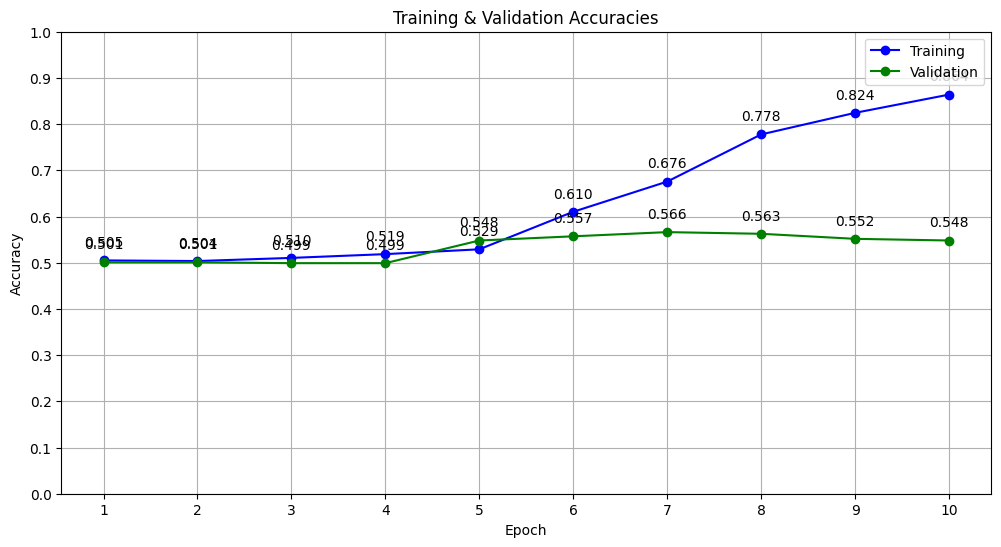

Training Accuracy: 0.8639
Training Loss: 0.3605
Validation Accuracy: 0.5481
Validation Loss: 1.0515

============ Transformer bert-base-cased has been successfully tested ============




train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.86388
train_loss,0.3605
val_acc,0.54809
val_loss,1.05147


In [ ]:
wandb.agent(sweep_id, train_sweep, count=1)